In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir('D:\shinj\Data\[3]dogVScat\Data\dogs-vs-cats'))

['test1.zip', 'sampleSubmission.csv', 'train.zip', 'test1', 'train']


In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
filenames = os.listdir(r'D:\shinj\Data\[3]dogVScat\Data\dogs-vs-cats\train\train')
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

<AxesSubplot:>

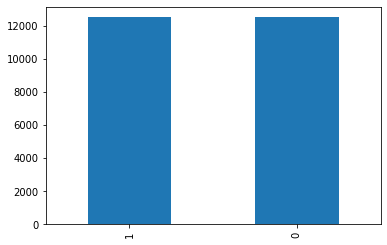

In [4]:
#balace확인
df['category'].value_counts().plot.bar()

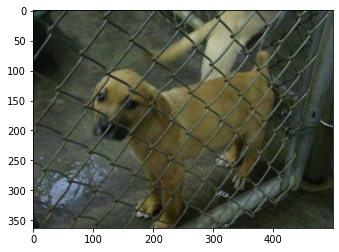

In [5]:
#샘플링 확인
sample = random.choice(filenames)
image = load_img(r'D:\shinj\Data\[3]dogVScat\Data\dogs-vs-cats\train\train/'+sample)
plt.imshow(image)


In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) #cause cat and dog class

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [20]:
#callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [8]:
#10회 이상 학습률 저하시 중지
earlystop = EarlyStopping(patience=10)

In [9]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [10]:
df['category'] = df['category'].replace({0: 'cat', 1:'dog'})

In [11]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

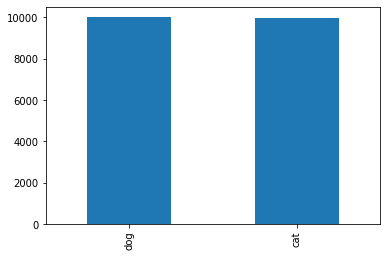

In [12]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

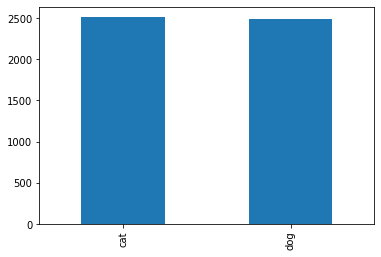

In [13]:
validate_df['category'].value_counts().plot.bar()

In [14]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    (r'D:\shinj\Data\[3]dogVScat\Data\dogs-vs-cats\train\train/'),
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [16]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    (r'D:\shinj\Data\[3]dogVScat\Data\dogs-vs-cats\train\train/'),
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 5000 validated image filenames belonging to 2 classes.


In [17]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
     example_df,
     (r'D:\shinj\Data\[3]dogVScat\Data\dogs-vs-cats\train\train/'),
     x_col='filename',
     y_col='category',
     target_size=IMAGE_SIZE,
     class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


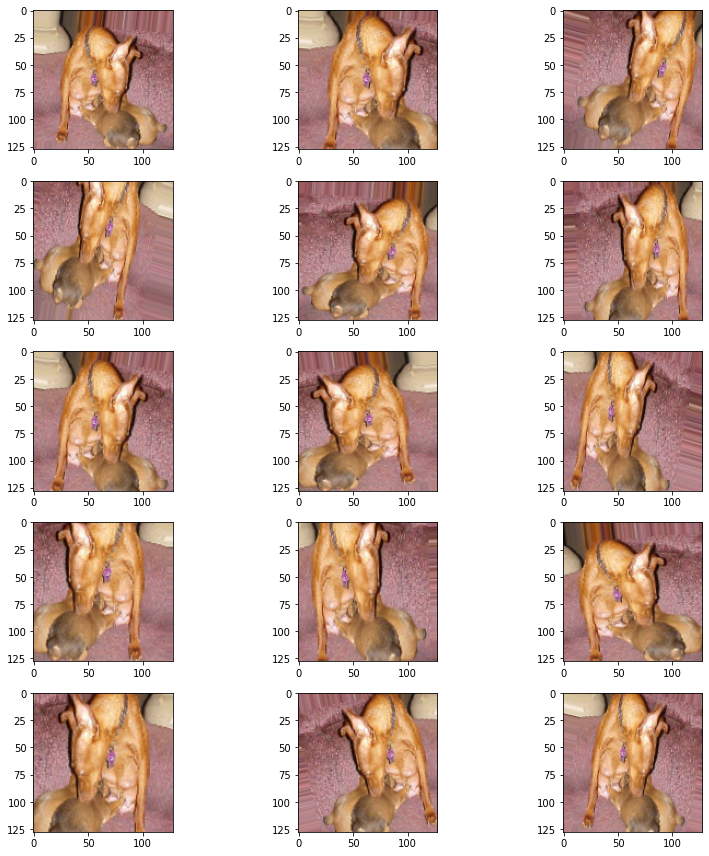

In [18]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for x_batch, y_batch in example_generator:
        image = x_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
  
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
1333/1333 [==============================] - 665s 499ms/step - loss: 0.7569 - accuracy: 0.6294 - val_loss: 0.5476 - val_accuracy: 0.7262
Epoch 2/50
1333/1333 [==============================] - 590s 442ms/step - loss: 0.5657 - accuracy: 0.7145
Epoch 3/50
1333/1333 [==============================] - 591s 443ms/step - loss: 0.4989 - accuracy: 0.7663
Epoch 4/50
1333/1333 [==============================] - 573s 430ms/step - loss: 0.4640 - accuracy: 0.7849
Epoch 5/50
1333/1333 [==============================] - 573s 430ms/step - loss: 0.4369 - accuracy: 0.8020
Epoch 6/50
1333/1333 [==============================] - 573s 430ms/step - loss: 0.4205 - accuracy: 0.8100
Epoch 7/50
1333/1333 [==============================] - 573s 430ms/step - loss: 0.4033 - accuracy: 0.8190
Epoch 8/50
1333/1333 [==============================] - 574s 430ms/step - loss: 0.3918 - accuracy: 0.8267
Epoch 9/50
1333/1333 [============

In [ ]:
model.save_weights('model.h5')

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label='Training loss')
ax1.plot(history.history['val_loss'], color='r', label='validation loss')
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label='Training accuracy')
ax2.plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()